In [32]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [33]:
from file_cache import *
os.environ["CUDA_VISIBLE_DEVICES"] = "2"


In [34]:
df = pd.read_csv('/home/felix/pj/thyroid_seg/input/TNSCUI2020_train/train.csv')
print(df.shape)
df.head()

(3644, 2)


,ID,CATE
0,5189.PNG,0
1,2090.PNG,1
2,5156.PNG,0
3,8303.PNG,1
4,9650.PNG,1


In [35]:
df.CATE.value_counts()

1    2003
0    1641
Name: CATE, dtype: int64

In [36]:
from fastai.vision import *
from fastai.callbacks.hooks import *

In [37]:

from file_cache import *

img_file_list = glob('/home/felix/pj/thyroid_seg/input/TNSCUI2020_train/image/*.PNG', recursive=True)

df = pd.DataFrame({'img_file':img_file_list})

df['label_path'] = df.img_file.apply(lambda val: val.replace('image', 'mask'))
df['sn'] = df.img_file.apply(lambda val: os.path.basename(val).split('.')[0]  ).astype(int)
df = df.sort_values('sn')

np.random.seed(2007)
df['fold'] = np.random.randint(0, 5, len(df))
df['valid'] = df.fold ==4
#df['valid'] = df.sn%5 >=4
df.head()

df['size1'] = df.label_path.apply(lambda val: cv2.imread(val).shape[0])
df['size2'] = df.label_path.apply(lambda val: cv2.imread(val).shape[1])
df.sort_values('size1')

codes = list(range(2))
print('codes', list(codes) )


src = (SegmentationItemList.from_df(df, path='/', cols='img_file' )
       .split_from_df(col='valid')
       .label_from_df(cols='label_path', classes=codes)
      )

codes [0, 1]


In [38]:
np.unique(cv2.imread(df.iloc[0,1]), return_counts=True)

(array([0, 1], dtype=uint8), array([866472,   6438]))

In [39]:
# for file in df.label_path:
#     #print(file)
#     img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
#     #print(img.shape)
#     cv2.imwrite(file, img/max(1, img.max()) )

## Datasets

In [40]:
size =224
bs = 4
print('size, bs', size, bs)

size, bs 224 4


In [41]:
 
    
print(len(src.train), len(src.valid), codes)

#get_transforms()
data = (src.transform(None, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

2887 757 [0, 1]


In [42]:
test_data = ImageList.from_folder(path="/share/data2/body/thyroid/test/image")
data.add_test(test_data, tfm_y=False)

In [43]:
# tmp = df.groupby(['p_id', 'valid'], as_index=False).label_path.count()
# tmp.pivot_table(index='p_id', columns='valid', values='label_path').sort_values(0)

In [44]:
for a, b in data.dl(DatasetType.Train):
    break
    
a.shape

torch.Size([4, 3, 224, 224])

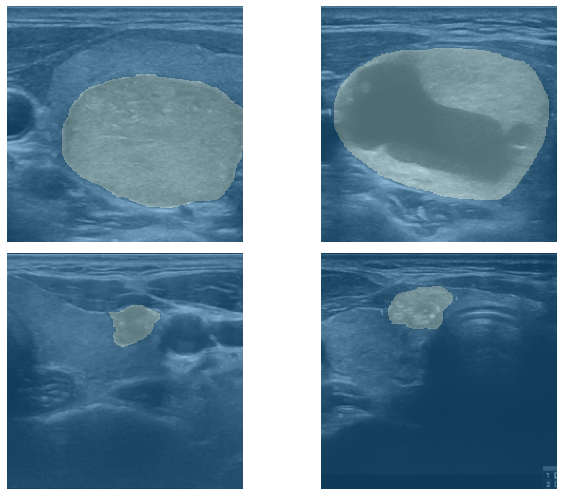

In [45]:
data.show_batch(8, figsize=(10, 7))

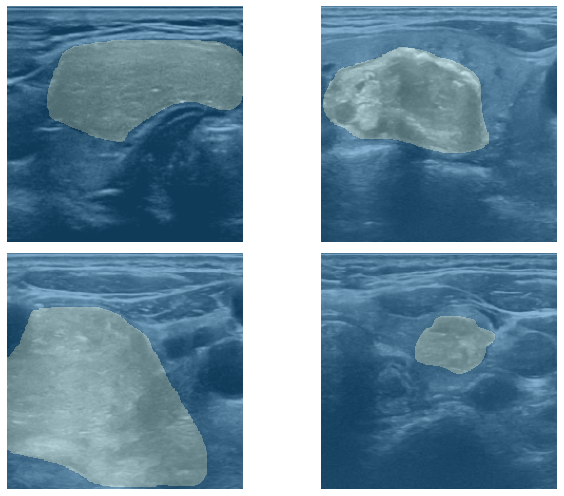

In [46]:
data.show_batch(4, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [47]:
name2id = {v:k for k,v in enumerate(codes)}
#void_code = name2id['Void']

# def acc_camvid(input, target):
#     target = target.squeeze(1)
#     mask = target != void_code
#     return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [48]:
wd = 1e-2


In [49]:
print('abc', data.c)

abc 2


In [50]:

def dice_multiply(logits, targets, cls_id=None):
    batch_size, class_cnt = logits.shape[0], logits.shape[1]

    dice_list = []
    for class_index in range(class_cnt):
        predict = logits.argmax(axis=1) == class_index
        target = (targets == class_index)

        predict = predict.view(batch_size, -1)
        target = target.view(batch_size, -1)

        # print('======', predict.shape,  target.shape)
        # print(predict.shape, logits.shape, target.shape)
        inter = torch.sum(predict * target, dim=1)
        union = torch.sum(predict, dim=1) + torch.sum(target, dim=1)
        dice = (2. * inter + 1) / (union + 1)
        # print(dice)
        dice = dice.mean()
        # print(dice, inter, union)
        dice_list.append(dice)
    # print(dice_list)
    if cls_id is None:
        return torch.Tensor(dice_list)
    else:
        return torch.Tensor(dice_list)[cls_id]


In [51]:
#多类别的Dice Metrics

#from brain.metrics import * 

from functools import partial
def dice_fn(cls_id):
    fn = partial(dice_multiply, cls_id=cls_id) 
    fn.__name__ = f'dice_{cls_id}'
    return fn
 

metrics = [ dice_fn(i) for i in codes ] #, accuracy,
print('len=', len(metrics))
#import ipdb
# ipdb.set_trace()
# learn = unet_learner(data, models.resnet50, metrics=metrics , wd=wd)

# for sn, child in enumerate(learn.model.children()):
#     print(sn, '===', child)

len= 2


In [52]:
from dynamic_unet.base import *
from efficientnet_pytorch import EfficientNet
eff=2
def unet_learner(data:DataBunch, arch:Callable, pretrained:bool=True, blur_final:bool=True,
                 norm_type:Optional[NormType]=None, split_on:Optional[SplitFuncOrIdxList]=None, blur:bool=False,
                 self_attention:bool=False, y_range:Optional[Tuple[float,float]]=None, last_cross:bool=True,
                 bottle:bool=False, cut:Union[int,Callable]=None, eff=eff, **learn_kwargs:Any)->Learner:
    
    
    encoder = efficient_unet(eff)
    unet = DynamicUnet(encoder, n_classes=2, img_size=(224, 224), blur=False, blur_final=False,
                    self_attention=False, y_range=None, norm_type=NormType,
                    last_cross=True,
                    bottle=False)
    
 
    learn = Learner(data, unet, **learn_kwargs)
    return learn

iou =  partial(dice, iou=True)
metrics = [ dice_fn(i) for i in codes ]
metrics = metrics + [dice, iou]
learn = unet_learner(data, unet_learner, metrics=metrics, wd=wd)

Loaded pretrained weights for efficientnet-b2
    sn                 layer     c    w    h               size
4    4           MBConvBlock    16  112  112  (1, 16, 112, 112)
7    7           MBConvBlock    24   56   56    (1, 24, 56, 56)
10  10           MBConvBlock    48   28   28    (1, 48, 28, 28)
18  18           MBConvBlock   120   14   14   (1, 120, 14, 14)
28  28  MemoryEfficientSwish  1408    7    7    (1, 1408, 7, 7)


In [53]:
os.path.abspath('./output/model')

'/share/felix/pj/thyroid_seg/output/model'

In [54]:

learn.model_dir=os.path.abspath('./output/model')
os.makedirs(learn.model_dir, exist_ok=True)
learn.lr_find()

epoch,train_loss,valid_loss,dice_0,dice_1,dice,dice,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


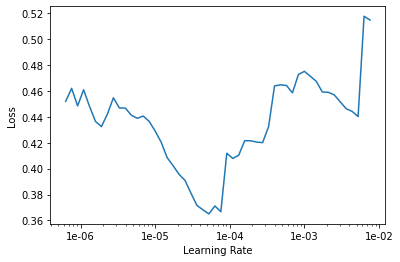

In [55]:
learn.recorder.plot()

In [56]:
print(eff)
lr = 1e-4
learn.fit_one_cycle(5, slice(lr), pct_start=0.9)


2


epoch,train_loss,valid_loss,dice_0,dice_1,dice,dice,time
0,0.192363,0.193234,0.954134,0.299032,0.297839,0.228034,02:18
1,0.151357,0.134074,0.965387,0.614060,0.613873,0.497204,02:20
2,0.105736,0.110490,0.975155,0.697963,0.697763,0.590380,02:19
3,0.084242,0.087086,0.978301,0.770781,0.770527,0.666667,02:22
4,0.052772,0.073466,0.981288,0.789487,0.789349,0.696908,02:21


In [57]:
print(eff)
lr = 1e-4
learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

2


epoch,train_loss,valid_loss,dice_0,dice_1,dice,dice,time
0,0.043191,0.080771,0.981721,0.805365,0.805254,0.714652,02:19
1,0.045625,0.082922,0.980010,0.791370,0.791257,0.698184,02:17
2,0.048574,0.075470,0.981532,0.813911,0.813838,0.720474,02:19
3,0.047857,0.130349,0.980433,0.802448,0.802353,0.709578,02:21
4,0.037735,0.113086,0.980715,0.817782,0.817691,0.729529,02:19


# Batch test end

In [58]:
lr = 1e-3
learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice_0,dice_1,dice,dice,time
0,0.057778,0.085045,0.980573,0.792268,0.792122,0.701377,02:21
1,0.101503,0.129650,0.969127,0.604777,0.604553,0.485896,02:18
2,0.135129,0.132399,0.975309,0.747090,0.747012,0.635993,02:19
3,0.101445,0.118023,0.974433,0.689729,0.689507,0.592438,02:20
4,0.061237,0.076163,0.980226,0.819175,0.819092,0.725153,02:20


In [59]:
lr = 1e-4
learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice_0,dice_1,dice,dice,time
0,0.056003,0.073255,0.980938,0.823382,0.823297,0.730764,02:18
1,0.048837,0.072730,0.981427,0.828261,0.828178,0.736868,02:15
2,0.056625,0.067370,0.982245,0.835002,0.834925,0.746314,02:19
3,0.041407,0.074667,0.982492,0.837890,0.837805,0.750441,02:16
4,0.039631,0.073217,0.981939,0.837524,0.837439,0.751232,02:17


In [60]:
lr = 1e-4
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice_0,dice_1,dice,dice,time
0,0.035802,0.073108,0.982275,0.840544,0.840467,0.754415,02:16
1,0.039464,0.072745,0.982511,0.841433,0.841352,0.756227,02:17
2,0.035024,0.075370,0.982649,0.841467,0.841387,0.755580,02:16
3,0.038823,0.074207,0.982870,0.844053,0.843980,0.759295,02:15
4,0.033962,0.078332,0.982795,0.844329,0.844252,0.759282,02:16
5,0.032685,0.083016,0.982924,0.841637,0.841548,0.757401,02:18
6,0.029508,0.087215,0.982816,0.845284,0.845198,0.760700,02:16
7,0.031297,0.079204,0.983353,0.845747,0.845649,0.762328,02:21
8,0.029831,0.084704,0.983674,0.844380,0.844299,0.760055,02:20
9,0.024653,0.096420,0.982923,0.843186,0.843090,0.759780,02:20


In [61]:
lr = 1e-5
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice_0,dice_1,dice,dice,time
0,0.023263,0.092851,0.983118,0.844658,0.844562,0.761818,02:19
1,0.029246,0.093608,0.983099,0.845336,0.845241,0.762594,02:19
2,0.024767,0.089320,0.983397,0.846742,0.846647,0.764055,02:20
3,0.026329,0.094336,0.983263,0.845569,0.845473,0.762861,02:22
4,0.026105,0.089722,0.983684,0.848464,0.848371,0.766343,02:21
5,0.024166,0.090802,0.983704,0.847997,0.847903,0.765665,02:19
6,0.023993,0.087800,0.983798,0.849350,0.849257,0.767168,02:19
7,0.022474,0.097041,0.983776,0.847388,0.847294,0.764699,02:20
8,0.024205,0.093917,0.983859,0.846739,0.846643,0.764461,02:18
9,0.023001,0.093298,0.983887,0.848845,0.848756,0.766852,02:19


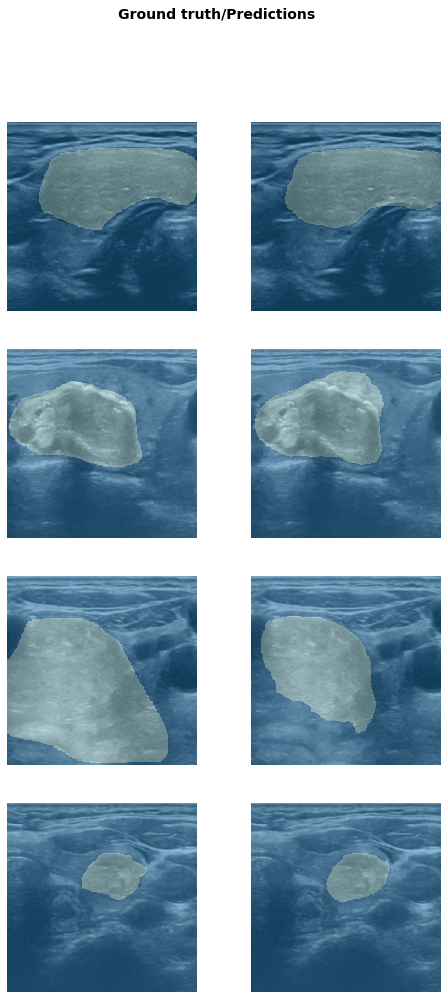

In [62]:
learn.show_results(DatasetType.Valid, rows=40)
